$$ a = \partial_t v =  \partial_t (p/\gamma) =  (\gamma \partial_t p  - p \partial_t \gamma)/\gamma^2 = $$

$$ = \frac{1}{2 dt \gamma} \Big[ \gamma ( p_2 -  p_1)  - (\gamma_1 + \gamma_2) ( p_2 -  p_1) \Big] $$


$$ | a |^2 = a a^* = (a'+ia'') (a'-ia'') =  (a')^2 - (ia'')^2 = a'^2 + a''^2$$

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import sys,time
import numpy as np
from scipy.constants import c,hbar
from scipy.interpolate import griddata

from chimera.moduls.species import Specie
from chimera.moduls.chimera_main import ChimeraRun
from chimera.moduls.SR import SR
from chimera.moduls import fimera as chimera

from synchrad import SynchRad

In [2]:
K0 = 0.1 
Periods=50
g0=100.0

StepsPerPeriod=24
gg = g0/(1.+K0**2/2)**.5
vb = (1.-gg**-2)**0.5
k_res = 2*gg**2
dt = 1./StepsPerPeriod
Steps2Do = int((Periods+2)/dt)+1

specie_in = { 'TimeStep':dt,
              'Devices':( [chimera.undul_analytic,
                          np.array([K0, 1., 0, Periods])], ) }

beam = Specie(specie_in)

NumParts = 1
beam.Data['coords'] = np.zeros((3,NumParts))
beam.Data['momenta'] = np.zeros((3,NumParts))

beam.Data['momenta'][0] = np.sqrt(g0**2-1)

beam.Data['coords_halfstep'] = beam.Data['coords'].copy()
beam.Data['weights'] = np.ones((NumParts,))/NumParts

chimera_in = {'Particles':(beam,),}
Chimera = ChimeraRun(chimera_in)

sr_in_far = {'Grid':[(0.02*k_res,1.1*k_res),
                     (0,2./g0),(0.,2*np.pi),
                     (200,200,24)],
         'TimeStep':dt,'Features':(),
        }

sr_calc_far = SR(sr_in_far)
sr_calc_far.init_track(Steps2Do,beam)

In [3]:
t0 = time.time()
for i in range(Steps2Do):
    Chimera.make_step(i)
    sr_calc_far.add_track(beam)
    
print('Done orbits in {:g} sec'.format(time.time()-t0))

t0 = time.time()
sr_calc_far.calculate_spectrum(comp='all')
print('Done farfield spectrum in {:g} min'.format((time.time()-t0)/60.))
t0 = time.time()

Done orbits in 0.0462301 sec
Done farfield spectrum in 1.40682 min


In [10]:
sr_in_far['ctx'] = [0,0]
calc = SynchRadCalculator(sr_in_far)

GPU DEVICE GeForce GTX 1080 Ti IS CHOSEN ON NVIDIA Corporation PLATFORM WITH OpenCL C 1.2  COMPILER


In [11]:
x, y, z = sr_calc_far.Data['coords'][:,:,0]
ux, uy, uz = sr_calc_far.Data['momenta_prv'][:,:,0]
w = sr_calc_far.Data['weights'][0]
particleTrack = [x, y, z, ux, uy, uz, w]

t0 = time.time()
calc.calculate_spectrum(particleTrack)
print('Done farfield spectrum in {:g} min'.format((time.time()-t0)/60.))

Done farfield spectrum in 0.0135879 min


<IPython.core.display.Javascript object>


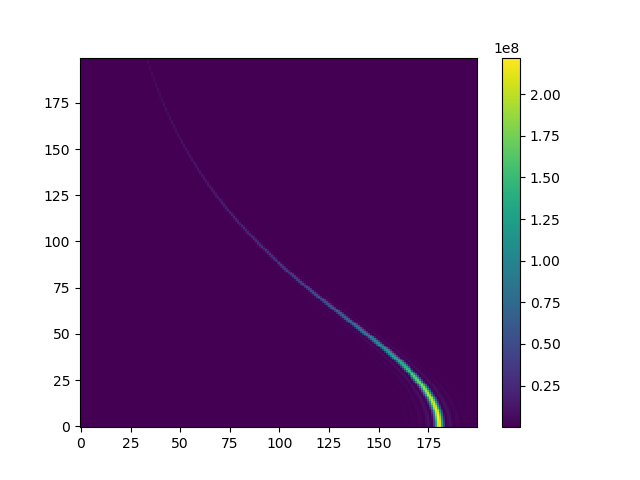

<IPython.core.display.Javascript object>


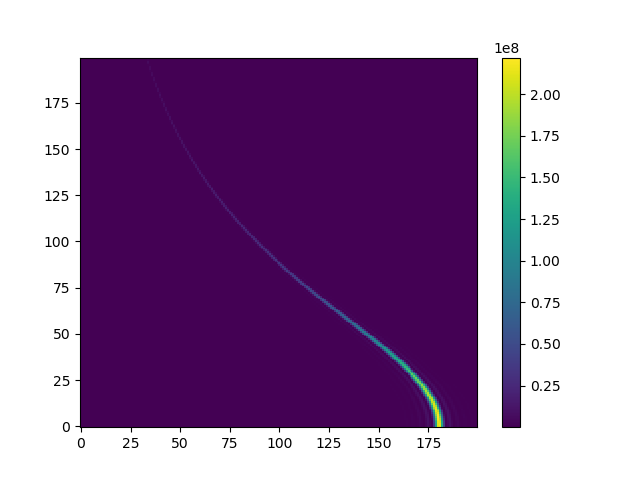

In [12]:
plt.figure()
plt.imshow(calc.Data['Rad'].sum(-1).T, origin='lower',aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(sr_calc_far.Data['Rad'].sum(-1).T, origin='lower',aspect='auto')
plt.colorbar()

In [28]:
spotXY_far, ext_far = calc.get_spot_cartesian(bins=(300,300), lambda0_um=1, k0=0.9*k_res, )


<IPython.core.display.Javascript object>


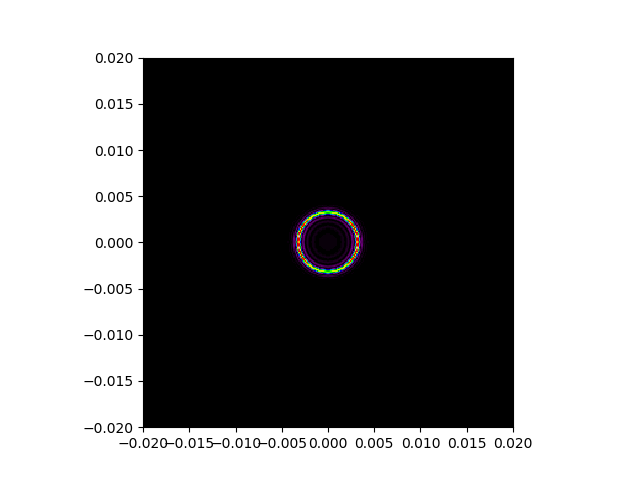

In [29]:
plt.figure()

plt.imshow(spotXY_far, extent=ext_far, cmap=plt.cm.nipy_spectral,  )

In [16]:
sr_calc_far.get_energy(lambda0_um=1, chim_units=False)

1.3917900724785988e-17